# plateSolve Example

This notebook will show you how to use the plateSolve package.

Let's start with setup - you'll need to import it something like this (note the sys.path.append). The other packages may be useful or will be necessary

In [2]:
%matplotlib inline
import sys
sys.path.append('/home/idies/workspace/Storage/treed28/persistent/homework_assignments/')
import plateSolve
from astropy.nddata import CCDData
import ccdproc
import os
from pathlib import Path

datadir = '/home/idies/workspace/Temporary/treed28/scratch/20240903/reduced/'
path = Path(datadir)
os.chdir(path) #Note the routines have only been tested when run from inside the 
               #directory holding the images.

ValueError: Error: Fitsh path does not exist. You need to change this to the correct path for your system (likely /home/idies/workspace/Storage/<username>/persistent/bin)

# Autosolve

Automatic solving should be as simple as passing the `plateSolve.autoSolve` function the name and CCDData object for the image.

In [3]:
image_name = 'TabbysStar_001R.fit'
image_ccd = CCDData.read(image_name,unit='adu')

check = plateSolve.autoSolve(image_name,image_ccd)
print("Check should be true if autoSolve worked correctly.")
print(image_name,check)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Check should be true if autoSolve worked correctly.
TabbysStar_001R.fit True


If successful, this should have created an image file that ends with .wcs.fit 
instead of just .fit, as well as a bunch of files that were created along the
way and aren't much use beyond that. We can delete them.

In [16]:
if check==True:
    plateSolve.cleanup(image_name)
    
    #With default arguments, this just warns you.
    #Uncomment the next line if you are happy deleting the files
    #plateSolve.cleanup(image_name,check=False)

Deleting the following files:
['TabbysStar_001R.wcs', 'TabbysStar_001R.match.csv', 'TabbysStar_001R.gaia.proj.plate', 'TabbysStar_001R.match.transform', 'TabbysStar_001R.stars.csv', 'TabbysStar_001R.gaia.proj', 'TabbysStar_001R.gaia.csv']
If you want to delete the files, rerun this command with check=False


# Using WCS 

We can now use the WCS information in the header of the new image tot do conversions between RA,dec and pixels, and vice versa.

In [14]:
from astropy.io import fits
import warnings
warnings.simplefilter("ignore")

d = fits.open('TabbysStar_001R.wcs.fit')
from astropy import wcs
wcsobj = wcs.WCS(d[0].header)
sky = wcsobj.pixel_to_world(100,100)
print(sky)

<SkyCoord (ICRS): (ra, dec) in deg
    (301.54824263, 44.40340862)>


# Manual Solve

The crossmatching used by autosolve is tempramental, and you may need to manually choose a list of stars for the plate solver to work with.

You can do this using the `plateSolve.manualSolvePlot` command to plot lists of stars to match up,
and `plateSolve.manualSolve` to perform the solve,

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
TabbysStar_001V.fit True
298.5675643916254 19.668535505506807
239.92711340050192 411.0790023725894


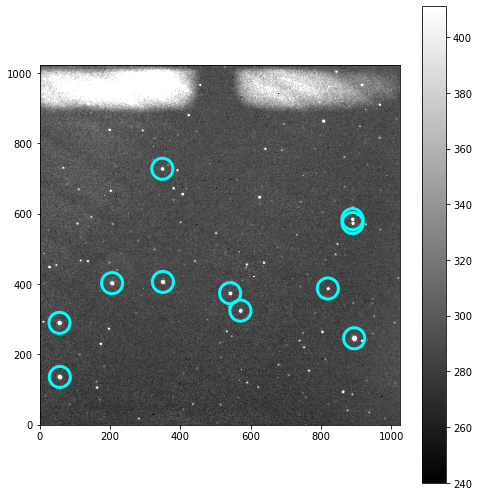

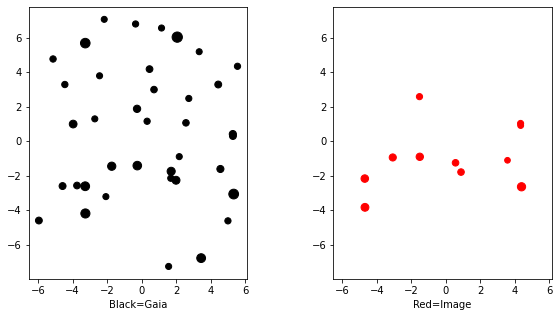

In [22]:
image_name = 'TabbysStar_001V.fit'
image_ccd = CCDData.read(image_name,unit='adu')

check = plateSolve.autoSolve(image_name,image_ccd,threshold=50) 
#I increased the starfind threshold to cut down on the number of stars detected
print(image_name,check)

#You need to have run autosolve first before 
#you can run the manual commands
#Let's assume the autoSolve failed, which isn't the case here.

#First, plot the image and reference star catalogs
plateSolve.manualSolvePlot(image_name,image_ccd)

Next look for asterisms that match between the Gaia catalog on the right, and stars found in the image on the left. Hover over the image to show the star ID numbers. You can use the marked stars on the image above to check if they are real or not. The more the better, but only include star you are sure you are in both lists if possible. You need at least 4 stars for a successful first order plateSolve, or 7 for a second order solve.

Make two lists of the stars that you are sure match up - one for Gaia, one for the image. Then run the `manualSolve`

In [23]:
gaia_list = [3,5,7,6,8,9,1,15,12]
image_list = [1,2,4,3,6,5,0,9,8]

check = plateSolve.manualSolve(image_name,image_ccd,gaia_list,image_list)
print("Check is True if successful")
print(image_name,check)

# Harder to solve cases

There are lots of variables you can tweak to try to fix a plate solve that won't work. You can list them all via the help function for autoSolve. Using the optional argument verbose=1 or higher will produce more output that can help diagnose a problem.

In [24]:
help(plateSolve.autoSolve)

Help on function autoSolve in module plateSolve:

autoSolve(imname, hdu, threshold=None, fwhm=4.0, fpnTrim=True, requeryGaia=True, GaiaROW_LIMIT=2000, searchRadiusScale=1.0, gaiaMagLimit=14.0, grmatch_nstars=None, grmatch_level=None, grmatch_crm='conformable', grmatch_maxdist=2.0, grmatch_order=1, manualSelect=False, returnDiagnostics=False, verbose=0)
    Attempt to automatically solve for the WCS of an image
    by:
       1. Finding stars in the image
       2. Downloading a reference catalog of stars from Gaia
       3. Crossmatching the stars in the image with Gaia's stars
       4. Solving for the plate equations
       5. Checking that the solution is sensible for the HRPO instrument.
    Solve for the WCS using external tool fitsh's grmatch and
    grtrans programs. Some arguments for these programs can be 
    adjusted.
    
    Required arguments:
        imname -- string with the image filename
        hdu    -- CCDData or individual astropy.io.fits HDU object
        
     